# Changes in API: Variational Inference: Bayesian Neural Networks

(c) 2017 by Thomas Wiecki & Maxim Kochurov (opvi)

See original blog post for old interface and more explanations of bayesian approach in Deep Learning:

http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/

## Bayesian Neural Networks in PyMC3

### Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable.

In [1]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

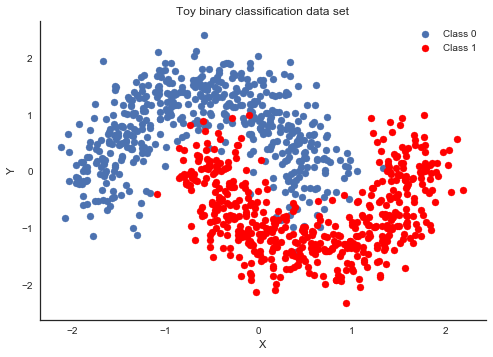

In [3]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

### Model specification

A neural network is quite simple. The basic unit is a [perceptron](https://en.wikipedia.org/wiki/Perceptron) which is nothing more than [logistic regression](http://pymc-devs.github.io/pymc3/notebooks/posterior_predictive.html#Prediction). We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [4]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

That's not so bad. The `Normal` priors help regularize the weights. Usually we would add a constant `b` to the inputs but I omitted it here to keep the code cleaner. Let's train the model using new ADVI implemented via [OPVI](https://arxiv.org/abs/1610.09033) framework

In [5]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [6]:
%%time

with neural_network:
    # Run ADVI to estimate posterior means, standard deviations, and the evidence lower bound (ELBO)
    # here is a good chance to demonstrate `cost_part_grad_scale` parameter usage
    # the reason is described here: approximateinference.org/accepted/RoederEtAl2016.pdf
    # to be short it is used to reduce variance of gradient on final iterations
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    pm.fit(n=20000, method=inference)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = pm.fit(n=30000)

Average Loss = 207.53: 100%|██████████| 20000/20000 [00:05<00:00, 3485.49it/s]
Finished [100%]: Average Loss = 207.62
Average Loss = 197.88: 100%|██████████| 30000/30000 [00:06<00:00, 4302.29it/s]
Finished [100%]: Average Loss = 197.88


CPU times: user 16.5 s, sys: 707 ms, total: 17.2 s
Wall time: 18.1 s


Let's compare performance with no grad scaling

In [7]:
set_tt_rng(MRG_RandomStreams(42))

In [8]:
%%time

with neural_network:
    inference_no_s = pm.ADVI()
    approx_no_s = pm.fit(n=30000, method=inference_no_s)

Average Loss = 196.86: 100%|██████████| 30000/30000 [00:06<00:00, 4397.40it/s]
Finished [100%]: Average Loss = 196.86


CPU times: user 7.77 s, sys: 300 ms, total: 8.07 s
Wall time: 7.95 s


And using old interface. Performance is nearly the same

In [9]:
%%time

with neural_network:
    advifit = pm.advi(n=30000)

Average ELBO = -202.84: 100%|██████████| 30000/30000 [00:06<00:00, 4771.85it/s]
Finished [100%]: Average ELBO = -199.58


CPU times: user 7.64 s, sys: 273 ms, total: 7.92 s
Wall time: 8.64 s


~ 30 sec on my laptop. That's pretty good considering that NUTS is having a really hard time. Further below we make this even faster. To make it really fly, we probably want to run the Neural Network on the GPU.

As samples are more convenient to work with, we can very quickly draw samples from the variational posterior using `approx.sample_vp()` (this is just sampling from Normal distributions, so not at all the same like MCMC):

In [11]:
trace = approx.sample(draws=5000)

Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.

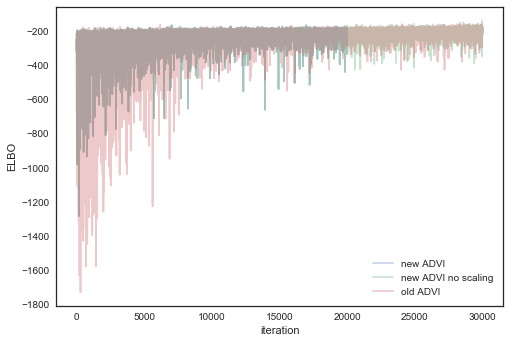

In [12]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.plot(-inference_no_s.hist, label='new ADVI no scaling', alpha=.3)
plt.plot(advifit.elbo_vals, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

Grad scaling seemd to give no effect, but let's see difference in variance of ELBO, that's really what is expected

In [13]:
inference.hist[25000:].var(), inference_no_s.hist[25000:].var()

(nan, 334.78659099948084)

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). 

1. We can use [`sample_ppc()`](http://pymc-devs.github.io/pymc3/api.html#pymc3.sampling.sample_ppc) to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).
2. It is better to get the node directly and build theano graph using our approximation (`approx.sample_node`) , we get a lot of speed up

In [14]:
# We can get predicted probability from model
neural_network.out.distribution.p

sigmoid.0

In [15]:
# create symbolic input
x = T.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p, size=n,
                                   more_replacements={ann_input:x})
# It is time to compile the function
# No updates are needed for Approximation random generator 
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

# Create bechmark functions
def production_step1():
    ann_input.set_value(X_test)
    ann_output.set_value(Y_test)
    ppc = pm.sample_ppc(trace, model=neural_network, samples=500, progressbar=False)

    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc['out'].mean(axis=0) > 0.5
    
def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5

See the difference

In [16]:
%timeit production_step1()

189 ms ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit production_step2()

33.4 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

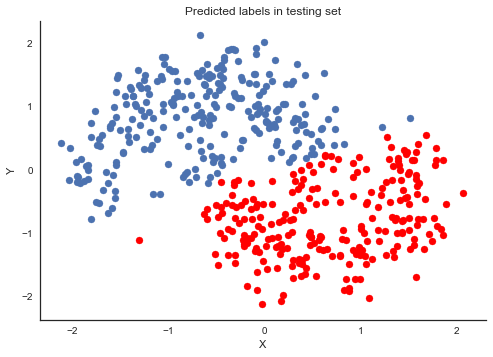

In [19]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [20]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 87.8%


Hey, our neural network did all right!

## Lets look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [21]:
grid = np.mgrid[-3:3:100j,-3:3:100j].astype(floatX)
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [22]:
# Creater posterior predictive samples
ppc = sample_proba(grid_2d ,500)

### Probability surface

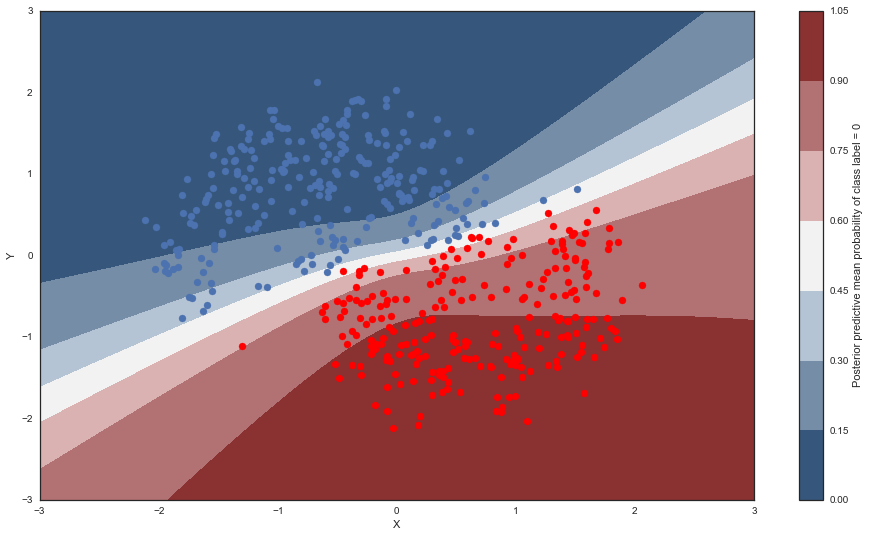

In [23]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

### Uncertainty in predicted value

So far, everything I showed we could have done with a non-Bayesian Neural Network. The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:

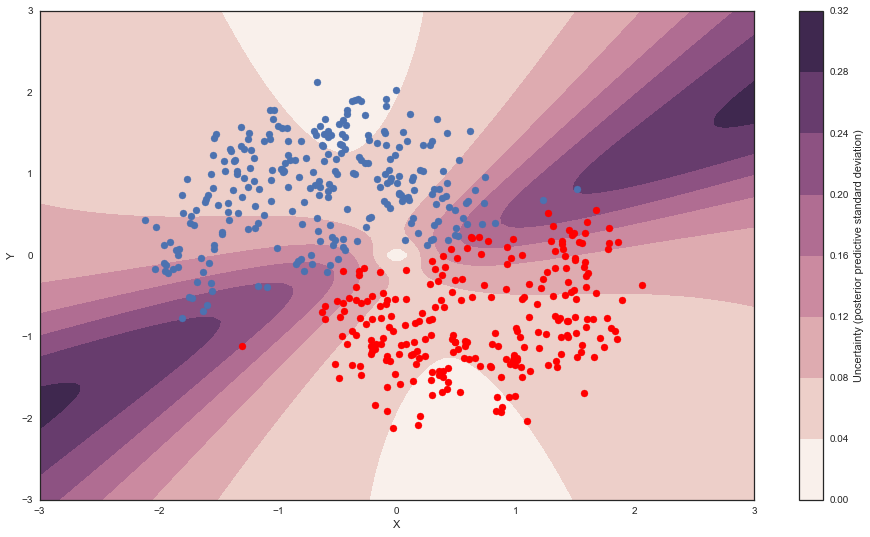

In [24]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

We can see that very close to the decision boundary, our uncertainty as to which label to predict is highest. You can imagine that associating predictions with uncertainty is a critical property for many applications like health care. To further maximize accuracy, we might want to train the model primarily on samples from that high-uncertainty region.

## Mini-batch ADVI: Scaling data size

So far, we have trained our model on all data at once. Obviously this won't scale to something like ImageNet. Moreover, training on mini-batches of data (stochastic gradient descent) avoids local minima and can lead to faster convergence.

Fortunately, ADVI can be run on mini-batches as well. It just requires some setting up:

In [25]:
# Generator that returns mini-batches in each iteration
def create_minibatch(data):
    rng = np.random.RandomState(0)
    
    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(len(data), size=50)
        yield data[ixs]


# Minibatch ADVI

All you need to train with minibatches is to wrap python generators with `pm.generator` function
The rest code should work without changes, let's see it

In [26]:
minibatch_x = pm.generator(create_minibatch(X_train))
minibatch_y = pm.generator(create_minibatch(Y_train))
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())

Average Loss = 186.53: 100%|██████████| 40000/40000 [00:08<00:00, 4820.69it/s]
Finished [100%]: Average Loss = 186.3


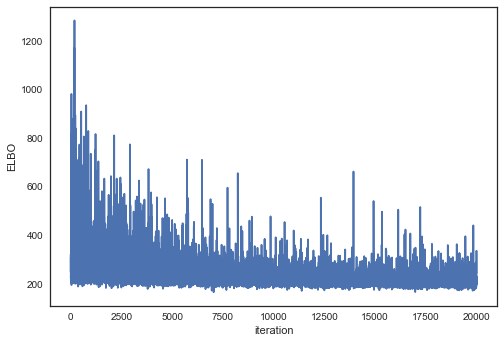

In [27]:
plt.plot(inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

It works!